# Obtain Intron TPMs of 100 nt within Intron-Exon Boundaries for Madrasin: DMS vs non-DMS

## Purpose
This script will get the intron TPMs of 100 nt within the intron-exon boundaries. A ranked list is created of all non-zero regions ranked by TPMs in introns. This is done seperately for intron depth within 5' of exon-intron boundary and 3' exon-intron boundary.

DataSet: Madrasin HiSeq Data from Oct 2018

This were read counts generated by the program featureCounts After Alignment using Bowtie2 ShapeMapper2 Parms

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Set variable to find highly expressed genes or transcripts
feature="Transcript"

In [3]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [4]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [5]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=0

In [6]:
# which end
whichend=str(5)

In [7]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/Madrasin_HiSeq_October2018_alignments/"):
    if ("_Intron"+whichend+"p_featureCounts_JustCounts.txt" in filename):
        print filename
        # Read the salmon output file
        with open("../tmp/Madrasin_HiSeq_October2018_alignments/"+filename) as f:
            lines = f.readlines()
        
        with open("../tmp/Madrasin_HiSeq_October2018_alignments/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        data_to_read = pd.read_csv("../tmp/Madrasin_HiSeq_October2018_alignments/"+filename.split('.')[0]+"_DropHeader.txt",header=0,sep="\t")
        
        data_to_read.columns = ["Name","Length","Count"]
        print(data_to_read.shape)
        #transcriptIDs_with_introns = list(geneNamesAndTranscriptIDs_withIntrons[1].values)
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            feats_with_introns = data_to_read["Name"].str.split("_").str[0] + "_" + data_to_read["Name"].str.split("_").str[1]
            #print(feats_with_introns.head())
            data_to_read = data_to_read[feats_with_introns.isin(geneNamesAndTranscriptIDs_withIntrons[1])]
        print(data_to_read.shape)
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        print(data_to_read.shape)
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        # Sort the data by TPMs
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

DMSTreatedSample_TAGGCATG_S1_Intron5p_featureCounts_JustCounts.txt
(1252882, 3)
(1252882, 3)
(1069896, 3)
NoDMSSample_CTCTCTAC_S2_Intron5p_featureCounts_JustCounts.txt
(1252882, 3)
(1252882, 3)
(1069896, 3)


In [8]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

1069896


In [9]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Madrasin_HiSeq_October2018_alignments/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if ("_Intron"+whichend+"p_featureCounts_JustCounts_DropHeader.txt" in filename):
        print filename
        current_columns.append(filename.split("_ExonIntron")[0])
        data_to_read = pd.read_csv("../tmp/Madrasin_HiSeq_October2018_alignments/"+filename,header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        transcriptIDs_for_data = data_to_read["Name"].str.split("_").str[0] + "_" + data_to_read["Name"].str.split("_").str[1]
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        print(data_GetFeatures.head())
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

NoDMSSample_CTCTCTAC_S2_Intron5p_featureCounts_JustCounts_DropHeader.txt
                Name  Length  Count  TPM
60  XM_024451962.1_1     100      0  0.0
61  XM_024451963.1_2     100      0  0.0
69  XM_024451962.1_4     100      0  0.0
70  XM_024451963.1_4     100      0  0.0
76  XM_011542538.1_1     100      0  0.0
DMSTreatedSample_TAGGCATG_S1_Intron5p_featureCounts_JustCounts_DropHeader.txt
                Name  Length  Count  TPM
60  XM_024451962.1_1     100      0  0.0
61  XM_024451963.1_2     100      0  0.0
69  XM_024451962.1_4     100      0  0.0
70  XM_024451963.1_4     100      0  0.0
76  XM_011542538.1_1     100      0  0.0


In [10]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(1069896, 2)


,NoDMSSample_CTCTCTAC_S2_Intron5p_featureCounts_JustCounts_DropHeader.txt,DMSTreatedSample_TAGGCATG_S1_Intron5p_featureCounts_JustCounts_DropHeader.txt
NM_000014.5_10,0.0,0.0
NM_000014.5_11,0.0,0.0
NM_000014.5_12,0.0,0.0
NM_000014.5_13,0.0,0.0
NM_000014.5_14,0.0,0.0


In [11]:
feature_readCounts_transcriptome.columns = ["NoDMSSample","DMSTreatedSample"]

In [13]:
feature_readCounts_transcriptome_sortedByTPMs = feature_readCounts_transcriptome.sort_values(by=["DMSTreatedSample"],ascending=False)
feature_readCounts_transcriptome_sortedByTPMs.head()

,NoDMSSample,DMSTreatedSample
NM_001101.4_4,1817.102000,2949.435125
NM_020529.2_2,2911.698235,2152.512543
NM_020529.2_4,1655.983215,2057.575603
NM_020529.2_1,1528.822200,1764.549086
NM_001321485.1_3,935.644966,1759.071955


In [14]:
# Load R GGplots
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(reshape)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Find out what's changed in ggplot2 at
https://github.com/tidyverse/ggplot2/releases.

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: reshape

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [15]:
# Melt the plus data
feature_readCounts_transcriptome_sortedByTPMs_melted = feature_readCounts_transcriptome_sortedByTPMs.melt(value_vars=["NoDMSSample","DMSTreatedSample"])
feature_readCounts_transcriptome_sortedByTPMs_melted.columns = ["Sample","TPM"]
feature_readCounts_transcriptome_sortedByTPMs_melted.head()

,Sample,TPM
0,NoDMSSample,1817.102000
1,NoDMSSample,2911.698235
2,NoDMSSample,1655.983215
3,NoDMSSample,1528.822200
4,NoDMSSample,935.644966


In [16]:
feature_readCounts_transcriptome_sortedByTPMs_melted.tail()

,Sample,TPM
2139787,DMSTreatedSample,0.0
2139788,DMSTreatedSample,0.0
2139789,DMSTreatedSample,0.0
2139790,DMSTreatedSample,0.0
2139791,DMSTreatedSample,0.0


[1] "../results/Madrasin_HiSeq_October2018_alignments/GGplot2-FrequencyTPMvaluesIn100bp5pIntronicRegions_Above100TPMs.png"


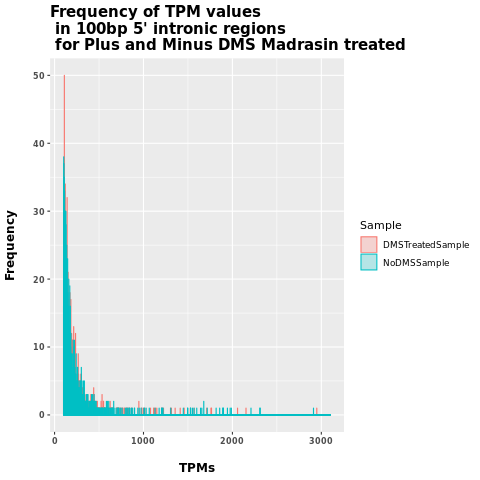

In [28]:
%%R -i feature_readCounts_transcriptome_sortedByTPMs_melted
maxTPM = max(feature_readCounts_transcriptome_sortedByTPMs_melted$TPM)
p<- ggplot(feature_readCounts_transcriptome_sortedByTPMs_melted, aes(x=TPM, fill=Sample, color=Sample)) +
  geom_histogram(alpha=0.25, binwidth=1,position="identity") +
    ggtitle("Frequency of TPM values\n in 100bp 5' intronic regions\n for Plus and Minus DMS Madrasin treated") +
    xlab("\nTPMs") +
    ylab("Frequency\n") +
    xlim(100,maxTPM) +
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         plot.title = element_text(face="bold",size=15))
#filenameToSave = "../results/Madrasin_HiSeq_October2018_alignments/GGplot2-FrequencyTPMvaluesIn100bp5pIntronicRegions_AllTPMs.png"
filenameToSave = "../results/Madrasin_HiSeq_October2018_alignments/GGplot2-FrequencyTPMvaluesIn100bp5pIntronicRegions_Above100TPMs.png"
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p